### テーマ

SRCNNモデルを用いた高解像度の画像への変換（課題番号001）

### 使用したモデル

**SRCNN**

* super-resolution CNN の略称。
* 登場自体は2015年で、超解像度を目的とするCNNの中では比較的古く、小さいモデルになる。
* このネットワークでは入力される画像サイズと出力される画像サイズは同じである（拡大は行われない）
* その小ささからちゃんとしたGPUがなくても動くとのことで、今回採用した。
* 参照論文：https://arxiv.org/pdf/1501.00092.pdf

### 使用したデータセット

**STL-10**

* スタンフォード大学が公開している10クラスの画像データセット。
  * DL元サイト：https://cs.stanford.edu/~acoates/stl10/
  * 学習用データ、テスト用データ、ラベルなしデータに分かれている。
  * 学習用データは1クラスにつき500枚。
  * テストデータは1クラスにつき800枚。
  * ラベルなしデータは10万枚ある。
  * CIFAR10 と比較すると、画像サイズが96×96であるため、より鮮明なデータとして扱える 
* 今回はモデルに読み込ませる低解像度の画像を高解像度の画像から作成するため、<br>ある程度低解像度化しても元の画像の特徴が潰れにくくなることを期待して採用した。
* 提出の際にデータが大きくなりすぎるため、今回は元画像の学習用データ5000枚から500枚を選んで学習に使用した。
  * 5000枚使ったものについては結果だけ記載
* テストにはテストデータの最初の画像を1枚使用した。

## 低解像度の画像の準備について

* 元となる画像を縮小し、古典的な手法（今回はOpenCVのデフォルトであるバイリニア補間を採用）で拡大したものを<br>低解像度の画像として扱った

## 評価関数について

* PSNR（ピーク信号対雑音比）を採用
* 数式としては以下になり、30db以上であれば綺麗に見えるとのこと

$$ PSNR =10 log_{10} \frac{MAX^2}{MSE} \\ $$

In [1]:
import os
import sys
import cv2
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as kl
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn import datasets
from sklearn.model_selection import train_test_split
%matplotlib inline
from PIL import Image, ImageFilter

# 乱数シードを指定
np.random.seed(seed=0)

# GPUが利用できることを確認
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## モデルのパラメータについて
- 概ね論文のパラメータを参照して設定（特に出力チャンネルの数）

### 学習

In [2]:
# SRCNN
class SRCNN(tf.keras.Model):
    def __init__(self, h, w):
        super(SRCNN, self).__init__()

        self.conv1 = kl.Conv2D(64, 3, padding='same', activation='relu', input_shape=(None, h, w, 3))
        self.conv2 = kl.Conv2D(32, 3, padding='same', activation='relu')
        self.conv3 = kl.Conv2D(3, 3, padding='same', activation='relu')

    def call(self, x):
        h1 = self.conv1(x)
        h2 = self.conv2(h1)
        h3 = self.conv3(h2)

        return h3


# 学習
class trainer(object):
    def __init__(self, h, w):
        self.model = SRCNN(h, w)

        self.model.compile(optimizer=tf.keras.optimizers.Adam(),
                            loss=tf.keras.losses.MeanSquaredError(),
                            metrics=[self.psnr])

    def train(self, lr_imgs, hr_imgs, out_path, batch_size, epochs):
        # 学習
        his = self.model.fit(lr_imgs, hr_imgs, batch_size=batch_size, epochs=epochs)

        print("___Training finished\n\n")

        # パラメータ保存
        print("___Saving parameter...")
        self.model.save_weights(out_path)
        print("___Successfully completed\n\n")

        return his, self.model

    # PSNR(ピーク信号対雑音比)
    """
    def psnr(self, h3, hr_imgs):
        return -10 * tf.math.log(tf.keras.metrics.Mean()(kl.Flatten()((h3 - hr_imgs))**2)) / np.log(10)
    """
    def psnr(self, h3, hr_imgs):
        return tf.image.psnr(h3, hr_imgs, max_val=1.0)


# データセット作成
def create_dataset(data_dir, mag):
    print("\n___Creating a dataset...")

    prc = ['/', '-', '\\', '|']
    cnt = 0

    # 画像データの個数
    print("Number of image in a directory: {}".format(len(os.listdir(data_dir))))

    lr_imgs = []
    hr_imgs = []

    for c in os.listdir(data_dir):
        d = os.path.join(data_dir, c)


        # 高解像度画像読込
        img = cv2.imread(d)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 低解像度画像作成
        img_low = cv2.resize(img, (int(img.shape[0] / mag), int(img.shape[1] / mag)))
        img_low = cv2.resize(img_low, (int(img.shape[0]), int(img.shape[1])))

        lr_imgs.append(img_low)
        hr_imgs.append(img)
        
        # データセットの一部をサンプルとして表示
        if cnt ==0:
            print("default Image sample")
            plt.imshow( img )
            plt.show()
            print("low-resolution Image sample")
            plt.imshow( img_low )
            plt.show()
            

        cnt += 1

        print("\rLoading a LR-images and HR-images...{}    ({} / {})".format(prc[cnt % 4], cnt, len(os.listdir(data_dir))), end='')

    print("\rLoading a LR-images and HR-images...Done    ({} / {})".format(cnt, len(os.listdir(data_dir))), end='')
    
    he = len(img_low)
    wi = len(img_low[0])

    # 正規化
    
    lr_imgs = tf.convert_to_tensor(lr_imgs, np.float32)
    lr_imgs /= 255
    hr_imgs = tf.convert_to_tensor(hr_imgs, np.float32)
    hr_imgs /= 255

    print("\n___Successfully completed\n")
    
    return lr_imgs, hr_imgs, he, wi


# PSNR, 損失値グラフ出力
def graph_output(history):
    # PSNRグラフ
    plt.plot(history.history['psnr'])
    plt.title('Model PSNR')
    plt.ylabel('PSNR')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')
    plt.show()

    # 損失値グラフ
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')
    plt.show()


def Training(data_dir, out, batch_size, epoch, mag):
    # コマンドラインオプション作成
    """
    parser = arg.ArgumentParser(description='Super-resolution CNN training')
    data_dir　：画像フォルダパスの指定(未指定ならエラー)
    out　　 　：パラメータの保存先指定
    batch_size：ミニバッチサイズの指定
    epoch　　 ：学習回数の指定
    mag　　　 ：縮小倍率の指定
    """

    # 画像フォルダパスが未指定の場合ストップ
    if data_dir is None:
        print("\nException: Folder not specified.\n")
        sys.exit()
    # 存在しない画像フォルダ指定時の場合ストップ
    if os.path.exists(data_dir) is False:
        print("\nException: Folder \"{}\" is not found.\n".format(data_dir))
        sys.exit()
    # 縮小倍率に0が入力された時の場合ストップ
    if mag == 0:
        print("\nException: Invalid value has been entered.\n")
        sys.exit()

    # 出力フォルダの作成(フォルダが存在する場合は作成しない)
    os.makedirs(out, exist_ok=True)
    out_path = os.path.join(out, "./srcnn.h5")

    # 設定情報出力
    print("=== Setting information ===")
    print("# Images folder: {}".format(os.path.abspath(data_dir)))
    print("# Output folder: {}".format(out_path))
    print("# Minibatch-size: {}".format(batch_size))
    print("# Epoch: {}".format(epoch))
    print("# Magnification: {}".format(mag))

    # データセット作成
    lr_imgs, hr_imgs, he, wi = create_dataset(data_dir, mag)
    
    print("# Height: {}".format(he))
    print("# Width: {}".format(wi))
    print("===========================\n")

    # 学習開始
    print("___Start training...")
    Trainer = trainer(he, wi)
    his, model = Trainer.train(lr_imgs, hr_imgs, out_path=out_path, batch_size=batch_size, epochs=epoch)

    # PSNR, 損失値グラフ出力、保存
    graph_output(his)


### 推論

In [5]:
def prediction(param, he, wi, mag, d, out):
    
    # パラメータファイル未指定時->例外
    if param is None:
        print("\nException: Trained Parameter-File not specified.\n")
        sys.exit()
    # 存在しないパラメータファイル指定時->例外
    if os.path.exists(param) is False:
        print("\nException: Trained Parameter-File {} is not found.\n".format(param))
        sys.exit()
    # 画像ファイル未指定時->例外
    if d is False:
        print("\nException: Image not specified.\n")
        sys.exit()
    # 存在しない画像ファイル指定時->例外
    if os.path.exists(d) is False:
        print("\nException: Image {} is not found.\n".format(d))
        sys.exit()
    # 幅高さ、縮小倍率いずれかに0が入力された時->例外
    if he == 0 or wi == 0 or mag == 0:
        print("\nException: Invalid value has been entered.\n")
        sys.exit()

    # 設定情報出力
    print("=== Setting information ===")
    print("# Trained Prameter-File: {}".format(os.path.abspath(param)))
    print("# Image: {}".format(d))
    print("# Output folder: {}".format(out))
    print("")
    print("# Height: {}".format(he))
    print("# Width: {}".format(wi))
    print("# Magnification: {}".format(mag))
    print("===========================")

    # 出力フォルダの作成(フォルダが存在する場合は作成しない)
    os.makedirs(out, exist_ok=True)
    
    model = SRCNN(he, wi)
    model.build((None, he, wi, 3))
    model.load_weights("./srcnn.h5")
    
    # 入力画像加工
    img = cv2.imread(d)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hr_img = cv2.resize(img, (he, wi))

    # 低解像度画像作成
    lr_img = cv2.resize(hr_img, (int(he / mag), int(wi / mag)))
    lr_img = cv2.resize(lr_img, (he, wi))
    lr_img_s = lr_img

    # 正規化
    lr_img = tf.convert_to_tensor(lr_img, np.float32)
    lr_img /= 255.0
    lr_img = lr_img[np.newaxis, :, :, :]

    # 超解像データの推論
    re = model.predict(lr_img)

    # データ加工
    re = np.reshape(re, (he, wi, 3))
    re *= 255
    re = np.clip(re, 0.0, 255.0)  # クリッピング(0~255に丸め込む)

    # 低解像度画像保存
    lr_img = Image.fromarray(np.uint8(lr_img_s))
    lr_img.show()
    lr_img.save(os.path.join(out, "Low-resolution Image(SRCNN).bmp"))
    print("low_resolution Image")
    plt.imshow( lr_img )
    plt.show()

    # 超解像度画像保存
    sr_img = Image.fromarray(np.uint8(re))
    sr_img.show()
    sr_img.save(os.path.join(out, "Super-resolution Image(SRCNN).bmp"))
    print("super-resolution Image")
    plt.imshow( sr_img )
    plt.show()

    # デフォルトの画像保存
    hr_img = Image.fromarray(np.uint8(hr_img))
    hr_img.show()
    hr_img.save(os.path.join(out, "High-resolution Image(SRCNN).bmp"))
    print("default Image")
    plt.imshow( hr_img )
    plt.show()

## テスト（教師データ500枚）

=== Setting information ===
# Images folder: C:\Users\watar\Repository\SRCNN\train_500
# Output folder: ./Output\./srcnn.h5
# Minibatch-size: 20
# Epoch: 100
# Magnification: 2

___Creating a dataset...
Number of image in a directory: 500
default Image sample


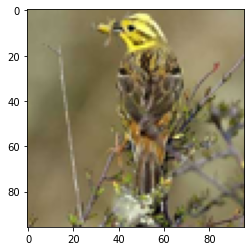

low-resolution Image sample


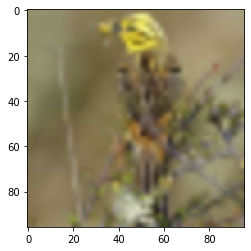

Loading a LR-images and HR-images...Done    (500 / 500)
___Successfully completed

# Height: 96
# Width: 96

___Start training...
Epoch 1/100
25/25 [==============================] - 7s 14ms/step - loss: 0.1272 - psnr: 9.4848
Epoch 2/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0391 - psnr: 16.0209
Epoch 3/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0080 - psnr: 21.6001
Epoch 4/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0044 - psnr: 24.1172
Epoch 5/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0034 - psnr: 25.2954
Epoch 6/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0031 - psnr: 25.7545
Epoch 7/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0030 - psnr: 26.0101
Epoch 8/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0029 - psnr: 26.1219
Epoch 9/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0028 - psnr: 26.332

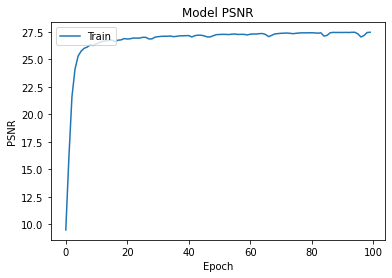

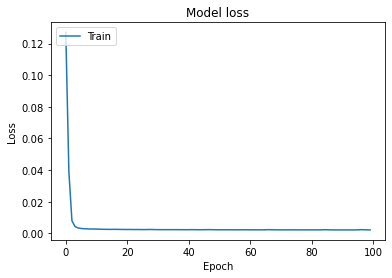

In [4]:
Training("./train_500","./Output", 20, 100, 2)

=== Setting information ===
# Trained Prameter-File: C:\Users\watar\Repository\SRCNN\Output\srcnn.h5
# Image: ./test.png
# Output folder: ./Output

# Height: 96
# Width: 96
# Magnification: 2
low_resolution Image


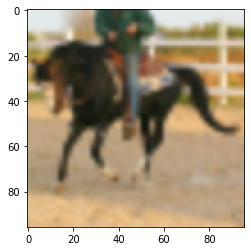

super-resolution Image


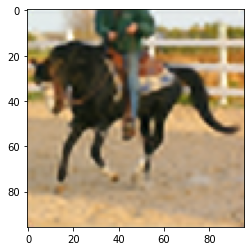

default Image


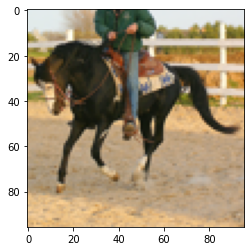

In [8]:
param = "./Output/srcnn.h5"
test_img = "./test.png"
output = "./Output"
prediction(param, 96, 96, 2, test_img, output)